In [1]:
import os
from openai import OpenAI
from dotenv import load_dotenv
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import f1_score, classification_report, multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer # Importante para multietiqueta


In [2]:


# Cargar CSV (usa sep=';' porque tu dataset está separado por punto y coma)
df = pd.read_csv("../data/dataset.csv", sep=";")

# Crear columna de etiquetas como listas
df['labels'] = df['group'].str.split('|')

# Lista de todas las clases únicas
all_labels = sorted(set(label for labels in df['labels'] for label in labels))
print(all_labels)
df.drop("group",inplace=True,axis=1)

['cardiovascular', 'hepatorenal', 'neurological', 'oncological']


In [3]:
df_sample=df.sample(50)

In [4]:
## open_ia_model

# Cargar variables de entorno desde .env
load_dotenv()

# Inicializar el cliente sin pasar manualmente la key
client = OpenAI()

# Probar
print("API Key cargada correctamente:", os.getenv("OPENAI_API_KEY")[:10] + "...")

import json

def classify_article(title, abstract, classes):
    prompt = f"""
    You are a medical article classifier.
    You must assign one or more relevant labels to the article from this fixed list:
    {classes}

    Return ONLY a valid JSON array with the labels. Example:
    ["neurological", "hepatorenal"]

    Title: {title}
    Abstract: {abstract}
    """

    response = client.chat.completions.create(
        model="gpt-4o-mini",  # Puedes usar "gpt-4.1" para más precisión
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    content = response.choices[0].message.content
    try:
        predicted = json.loads(content)
    except:
        predicted = []
    return predicted


API Key cargada correctamente: sk-proj-XJ...


In [5]:
df_sample['group_predicted'] = [
    classify_article(row['title'], row['abstract'], all_labels)
    for _, row in tqdm(df_sample.iterrows(), total=len(df_sample))]

100%|██████████| 50/50 [00:31<00:00,  1.57it/s]


In [6]:
mlb = MultiLabelBinarizer(classes=all_labels)
y_true = mlb.fit_transform(df_sample['labels'])
y_pred = mlb.transform(df_sample['group_predicted'])

In [7]:
# Exact Match Ratio
exact_match = accuracy_score(y_true, y_pred)
print(f"Exact Match Ratio: {exact_match:.4f}")

# F1-Score micro, macro y weighted
print("F1 Micro:", f1_score(y_true, y_pred, average='micro'))
print("F1 Macro:", f1_score(y_true, y_pred, average='macro'))
print("F1 Weighted:", f1_score(y_true, y_pred, average='weighted'))

# Reporte completo
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=all_labels))


Exact Match Ratio: 0.3200
F1 Micro: 0.7204968944099379
F1 Macro: 0.7032463330457291
F1 Weighted: 0.7531721057706948

Classification Report:
                 precision    recall  f1-score   support

cardiovascular       0.61      0.93      0.74        15
   hepatorenal       0.75      0.75      0.75        12
  neurological       0.87      0.84      0.85        31
   oncological       0.32      0.90      0.47        10

     micro avg       0.62      0.85      0.72        68
     macro avg       0.64      0.86      0.70        68
  weighted avg       0.71      0.85      0.75        68
   samples avg       0.68      0.89      0.73        68



c:\Users\Juan Felipe\Documents\GitHub\techspere_data_challenge\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


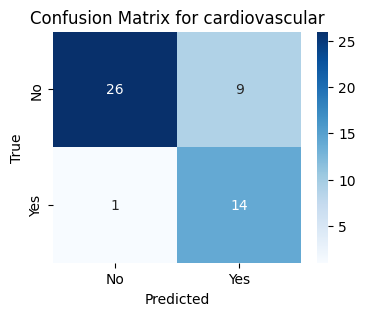

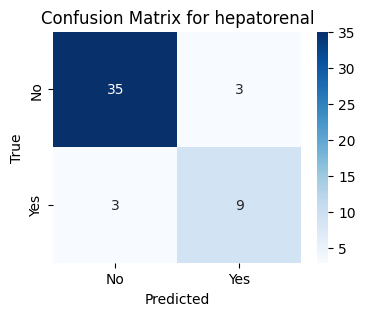

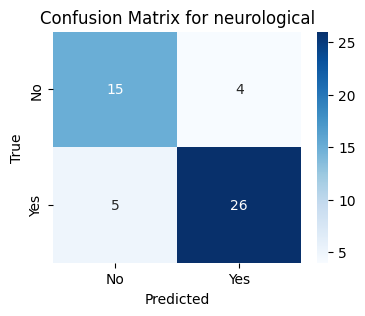

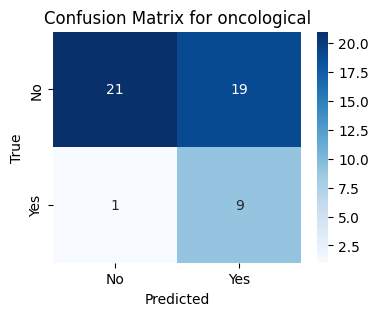

In [8]:
mcm = multilabel_confusion_matrix(y_true, y_pred)

for i, label in enumerate(all_labels):
    cm = mcm[i]
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.title(f"Confusion Matrix for {label}")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()
